In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, misc
import scipy
from scipy.io import wavfile 
from scipy.fft import fft, fftfreq
from librosa import display
import librosa 
import IPython.display as ipd 
from PIL import Image
import skimage.io
import cv2
import math


In [245]:

AudioName = "ElCoronelRapido.wav" # Archivo sde Audio
tasaMuestreo, info = wavfile.read(AudioName)
data, fs = librosa.load(AudioName, sr = 60000)
print("Frecuencia de muestreo  =  Muestras/Seg: ", fs )
print("Duración: ", data.shape[0]/fs)
print("tipo de dato: ", data.dtype)
ipd.Audio(AudioName) # Reproduce el audio directamente en el Jupyter notebook.

Frecuencia de muestreo  =  Muestras/Seg:  60000
Duración:  4.053333333333334
tipo de dato:  float32


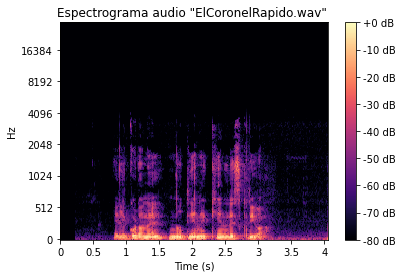

In [247]:

D = librosa.stft(data, n_fft=512)  # tranformada corta de fourier
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots()
espectrograma = librosa.display.specshow(S_db, sr=60000, hop_length=128,   x_axis='s', y_axis='mel', ax=ax)
ax.set(title='Espectrograma audio "ElCoronelRapido.wav" ')
fig.colorbar(espectrograma, ax=ax, format="%+2.f dB")

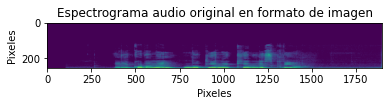

In [248]:
#Transformamos la información como una imagen

espectrogramaImage = np.flip(espectrograma.to_rgba(espectrograma.get_array().reshape(S_db.shape)), axis=0)
espectrogramaImage = skimage.color.rgb2gray(skimage.color.rgba2rgb(espectrogramaImage))
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Espectrograma audio original en formato de imagen')
plt.imshow(espectrogramaImage)


In [250]:

start = 2.6
end =  3.15

wavfile.write("fonemaTiene.wav",
fs, data[int(start*fs):int(end*fs)])

fonemaData, fonemaFs = librosa.load("fonemaTiene.wav", 
sr=60000)

ipd.Audio(fonemaData, rate=fonemaFs)

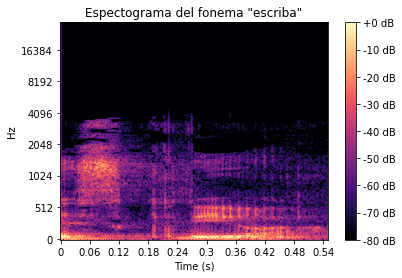

In [233]:
#Espectrograma de la palabra "escriba"


fonemafft = librosa.stft(fonemaData, n_fft=512) 
fonemaAmplitud = librosa.amplitude_to_db(np.abs(fonemafft), ref=np.max)
fig2, ax2 = plt.subplots()
espectrogramaFonema = librosa.display.specshow(fonemaAmplitud, sr=60000, hop_length =128 , x_axis='s', y_axis='mel', ax=ax2)
ax2.set(title='Espectograma del fonema "escriba"')
plt.colorbar(espectrogramaFonema, ax=ax2, format="%+2.f dB")
ipd.Audio(fonemaData, rate=fonemaFs)



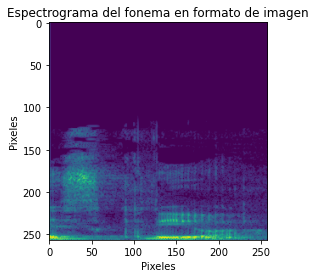

In [234]:

espectrogramaImageSinRecorte = np.flip(espectrogramaFonema.to_rgba(espectrogramaFonema.get_array().reshape(fonemaAmplitud.shape)), axis=0)
espectrogramaImageSinRecorte = skimage.color.rgb2gray(skimage.color.rgba2rgb(espectrogramaImageSinRecorte))
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Espectrograma del fonema en formato de imagen')
plt.imshow(espectrogramaImageSinRecorte)

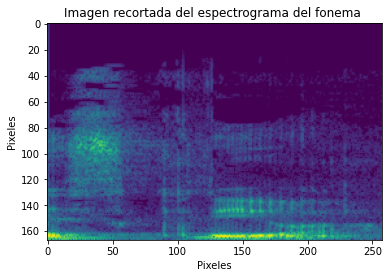

In [252]:
#Las frecuencias inferirores, serán tomadas como aquellas que 
#caracterizan o representan la palabra.

fonEspectrogR = np.flip(espectrogramaFonema.to_rgba(espectrogramaFonema.get_array().reshape(fonemaAmplitud.shape)), axis=0)
fonEspectrogR = skimage.color.rgb2gray(skimage.color.rgba2rgb(fonEspectrogR))
fonEspectrogRecortado = fonEspectrogR[ 90:fonEspectrogR.shape[0] ,0:fonEspectrogR.shape[1]]
plt.savefig('fonEspectrogRecortado.jpg')
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Imagen recortada del espectrograma del fonema ')
plt.imshow(fonEspectrogRecortado)


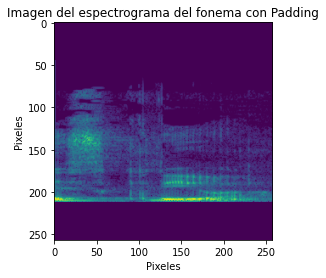

In [236]:
#Haciendole padding a los datos del fonema seleccionado 
#Esto con el fin de que podamos luego realizar la correlación cruzada

m = int( (fonEspectrogRecortado.shape[1]-fonEspectrogRecortado.shape[0])/2)

fonEspectrogRecortadoPadding = np.pad(fonEspectrogRecortado, ((m,m),(0,0)),  mode = 'constant', constant_values=(0,0))
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Imagen del espectrograma del fonema con Padding')
plt.imshow(fonEspectrogRecortadoPadding)


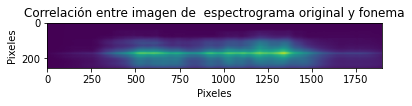

In [239]:


correlaCruzada = np.flip(scipy.signal.correlate2d(espectrogramaImage, fonEspectrogRecortadoPadding, mode = 'same') , axis=0)
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Correlación entre imagen de  espectrograma original y fonema')
plt.imshow(np.flip(correlaCruzada, axis=0))




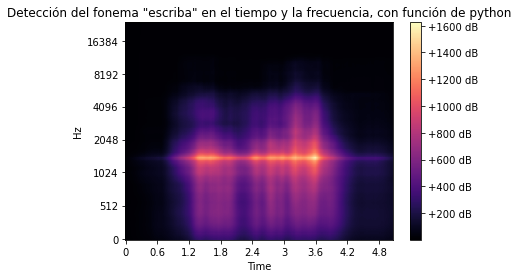

In [243]:

fig3, ax3 = plt.subplots()
espectrogramaFonemaIdentificado = librosa.display.specshow(correlaCruzada, sr=tasaMuestreo, hop_length =128 ,  x_axis='time', y_axis='mel', ax=ax3)
ax3.set(title='Detección del fonema "escriba" en el tiempo y la frecuencia, con función de python')
plt.colorbar(espectrogramaFonemaIdentificado, ax=ax3, format="%+2.f dB")

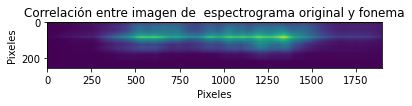

In [242]:
anchoOriginal=espectrogramaImage.shape[1]                    
altoOriginal=espectrogramaImage.shape[0]                   

palabraAncho = fonEspectrogRecortadoPadding.shape[1]     
palabraAlto = fonEspectrogRecortadoPadding.shape[0]      

k=1 
q = ((palabraAncho-1)/2) 

espectroAjustado = np.pad(espectrogramaImage, ((int(q),int(q)),(int(q),int(q))),   mode = 'constant', constant_values=(0,0))
altoSalida=math.floor(((altoOriginal+2*q-palabraAlto)/k) +1)
anchoSalida=math.floor(((anchoOriginal+2*q-palabraAncho)/k) +1)

def dosDimensionesCorre(original, fonema):
    anchoOriginal=espectrogramaImage.shape[1]                    
    altoOriginal=espectrogramaImage.shape[0]                   
    
    palabraAncho = fonEspectrogRecortadoPadding.shape[1]     
    palabraAlto = fonEspectrogRecortadoPadding.shape[0]      
    
    salida =np.zeros((altoSalida, anchoSalida))
    for colum in range(anchoOriginal):
        if colum > anchoOriginal :
            break
        if colum % k == 0:
            for row in range(altoOriginal):
                if row > altoOriginal :
                    break
                try: 
                    if row % k == 0:
                        salida[row, colum] = (fonema * original[row: row + palabraAlto,colum: colum + palabraAncho]).sum()
                except:
                    break
    return salida

correlacionCruzada2 = np.flip((dosDimensionesCorre(espectroAjustado,fonEspectrogRecortadoPadding )),axis=0)
plt.xlabel('Pixeles')
plt.ylabel('Pixeles')
plt.title('Correlación entre imagen de  espectrograma original y fonema')
plt.imshow(correlacionCruzada2)

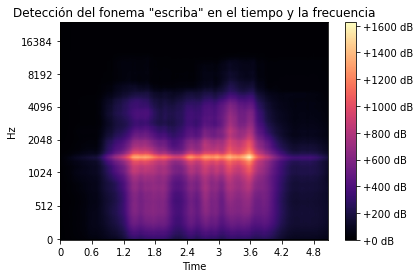

In [244]:

fig4, ax4 = plt.subplots()
espectroGramaFonema = librosa.display.specshow(correlacionCruzada2, sr=tasaMuestreo, hop_length =128 ,  x_axis='time', y_axis='mel', ax=ax4)
ax4.set(title='Detección del fonema "escriba" en el tiempo y la frecuencia')
plt.colorbar(espectroGramaFonema, ax=ax4, format="%+2.f dB")
